In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"13xmiSh8AgQjj6BJ7Dxu_byo59bnlUT8h"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
import warnings; warnings.simplefilter('ignore')

In [7]:
dataset = pd.read_csv('data.csv',encoding="ISO-8859-1") #dataset incorporation
dataset.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [8]:
print(dataset.info()) #printing dataset info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [0]:
dataset.head() #printing dataset head for confirmation

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [9]:
# DATA CLEANING AND PREPROCESSING STARTS HERE

# dropping the unnecessary columns from the dataset
dataset.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1,inplace=True)
dataset.info()  # printing info
dataset.head()  # printing top 5 rows for checking

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   state     435742 non-null  object 
 1   location  435739 non-null  object 
 2   type      430349 non-null  object 
 3   so2       401096 non-null  float64
 4   no2       419509 non-null  float64
 5   rspm      395520 non-null  float64
 6   spm       198355 non-null  float64
 7   pm2_5     9314 non-null    float64
 8   date      435735 non-null  object 
dtypes: float64(5), object(4)
memory usage: 29.9+ MB


,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [10]:
# Finding missing values in the data set 
total = dataset.isnull().sum()[dataset.isnull().sum() != 0]  # finding total null values
percent = pd.Series(round(total/len(dataset)*100,2))         # calculatig the percentage of null values
pd.concat([total, percent], axis=1, keys=['total_missing', 'percent'])  # printing the amount of percentage of null values in the columns of the dataset

,total_missing,percent
location,3,0.00
type,5393,1.24
so2,34646,7.95
no2,16233,3.73
rspm,40222,9.23
spm,237387,54.48
pm2_5,426428,97.86
date,7,0.00


In [0]:
# Removing outliers ( )
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)  #it is middle number between smallest value and median
    q3 = df_in[col_name].quantile(0.75) #it is middle number between largest value and median
    iqr = q3-q1    #Interquartile range
    low_range  = q1-1.5*iqr  #any number suspected lower than this value is suspected outlier
    high_range = q3+1.5*iqr  #any number suspected higher than this value is suspected outlier
    df_out = df_in.loc[(df_in[col_name] > low_range) & (df_in[col_name] < high_range)]   # limiting the dataset values to just the range where outliers does not exists

# calling function to remove outlier values from the pollutant columns of the dataset
remove_outlier(dataset,'so2')
remove_outlier(dataset,'no2')
remove_outlier(dataset,'rspm')
remove_outlier(dataset,'spm')

In [12]:
dataset.groupby('state')[['spm','pm2_5','rspm','so2','no2']].mean()  ##statewise mean of all the features considered

,spm,pm2_5,rspm,so2,no2
state,,,,,
Andhra Pradesh,200.260378,NaN,78.182824,7.284845,21.704451
Arunachal Pradesh,NaN,NaN,76.629213,3.179104,5.469697
Assam,153.355386,NaN,93.724912,6.723263,14.793691
Bihar,276.917416,NaN,123.705176,19.381476,36.575525
Chandigarh,206.056150,NaN,96.587079,2.676986,18.619404
Chhattisgarh,231.290969,NaN,126.472399,12.846609,24.815961
Dadra & Nagar Haveli,170.545024,30.511628,76.536530,8.939587,18.293959
Daman & Diu,145.681416,27.886364,73.749431,8.192958,16.168926
Delhi,399.402088,95.113208,196.639771,8.737273,53.489147


In [0]:
statewise = dataset.groupby('state')      #grouping dataset by state

# filling the nan values with the mean of that column 
def calc_mean(series):
    return series.fillna(series.mean()) 

dataset['rspm'] = statewise['rspm'].transform(calc_mean) #transforming null values in rspm column
dataset['so2'] = statewise['so2'].transform(calc_mean) #transforming null values in so2 column
dataset['no2'] = statewise['no2'].transform(calc_mean) #transforming null values in no2 column
dataset['spm'] = statewise['spm'].transform(calc_mean)#transforming null values in spm column
dataset['pm2_5'] = statewise['pm2_5'].transform(calc_mean) #transforming null values in pm25 column

In [14]:
# Derivation for Individual Pollutant Index and AQI STARTS HERE

# EPA METHOD FORMULA
#  AQI_{P} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SO2 pollutant by EPA method formula given above
#  SO2 is scaled between 0-1600
def calculate_si(so2):
    si=0
    if (so2<=40):
     si = so2 * (50/40)
    elif (so2>40 and so2<=80):
     si = 50 + (so2-40) * (50/(80-40))
    elif (so2>80 and so2<=380):
     si = 100 + (so2-80) * (100/(380-80))
    elif (so2>380 and so2<=800):
     si = 200 + (so2-380) * (100/(800-380))
    elif (so2>800 and so2<=1600):
     si = 300 + (so2-800) * (100/(1600-800))
    elif (so2>1600):
     si = 400 + (so2-1600) * (100/800)
    return si

# calling the function to calulate so2 pollutant index
dataset['si'] = dataset['so2'].apply(calculate_si)
df_si = dataset[['so2','si']]
df_si.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [15]:
#Function to calculate no2 individual pollutant index(ni)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of NO2 pollutant by EPA method formula given above
#  NO2 is scaled between 0-400
def calculate_ni(no2):
    ni = 0
    if(no2<=40):
     ni = no2*50/40
    elif(no2>40 and no2<=80):
     ni = 50 + (no2-40)*(50/(80-40))
    elif(no2>80 and no2<=180):
     ni = 100 + (no2-80)*(100/(180-80))
    elif(no2>180 and no2<=280):
     ni = 200 + (no2-180)*(100/(280-180))
    elif(no2>280 and no2<=400):
     ni = 300 + (no2-280)*(100/(400-280))
    else:
     ni = 400 + (no2-400)*(100/120)
    return ni

# calling the function to calulate so2 pollutant index
dataset['ni'] = dataset['no2'].apply(calculate_ni)
df_ni = dataset[['no2','ni']]
df_ni.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [16]:
#Function to calculate rspm individual pollutant index(rpi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of RSPM pollutant by EPA method formula given above
#  RSPM is scaled between 0-400
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi = rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi = 50+(rpi-30)*50/(60-30)
    elif(rpi>60 and rpi<=90):
     rpi = 100+(rpi-60)*100/(90-60)
    elif(rpi>90 and rpi<=120):
     rpi = 200+(rpi-90)*100/(120-90)
    elif(rpi>120 and rpi<=250):
     rpi = 300+(rpi-120)*(100/(250-120))
    else:
     rpi = 400+(rpi-250)*(100/130)
    return rpi

# calling the function to calulate RSPM pollutant index
dataset['rpi']=dataset['rspm'].apply(calculate_si)
df_rpi = dataset[['rspm','rpi']]
df_rpi.head()


,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


In [17]:
#Function to calculate spm individual pollutant index(spi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SPM pollutant by EPA method formula given above
#  SPM is scaled between 0-400
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi = spm*50/50
    elif(spm>50 and spm<=100):
     spi = 50 + (spm-50)*(50/(100-50))
    elif(spm>100 and spm<=250):
     spi = 100 + (spm-100)*(100/(250-100))
    elif(spm>250 and spm<=350):
     spi=200 + (spm-250)*(100/(350-250))
    elif(spm>350 and spm<=430):
     spi=300 + (spm-350)*(100/(430-350))
    else:
     spi=400+(spm-430)*(100/430)
    return spi

# calling the function to calulate SPM pollutant index
dataset['spi'] = dataset['spm'].apply(calculate_spi)
df_spm = dataset[['spm','spi']]
df_spm.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


In [18]:
#function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards

# AQI = MAX ( AQI_{SO2}, AQI_{NO2}, AQI_{RSPM}, AQI_{SPM})
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

# calling the function to calulate AQI 
dataset['AQI'] = dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= dataset[['state','si','ni','rpi','spi','AQI']]
df.head()

,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


In [19]:
# Exploring air pollution state-wise

# filling 0 in the place of NAN values
dataset.fillna(0.0,inplace=True)
state=dataset.groupby(['state'],as_index=False).mean()  # calulating mean of the pollutant concentration for each state
state

,state,so2,no2,rspm,spm,pm2_5,si,ni,rpi,spi,AQI
0,Andhra Pradesh,7.284845,21.704451,78.182824,200.260378,0.000000,9.079979,27.107882,87.056537,169.044212,169.368980
1,Arunachal Pradesh,3.179104,5.469697,76.629213,0.000000,0.000000,3.973881,6.837121,84.939295,0.000000,0.000000
2,Assam,6.723263,14.793691,93.724912,153.355386,0.000000,8.404079,18.488802,89.952232,135.037963,136.317972
3,Bihar,19.381476,36.575525,123.705176,276.917416,0.000000,23.941127,45.586000,111.725990,228.723971,229.499535
4,Chandigarh,2.676986,18.619404,96.587079,206.056150,0.000000,3.346232,23.271826,96.646110,174.128162,174.262893
5,Chhattisgarh,12.846609,24.815961,126.472399,231.290969,0.000000,16.058262,31.019569,113.951111,190.875168,191.247367
6,Dadra & Nagar Haveli,8.939587,18.293959,76.536530,170.545024,30.511628,11.174483,22.867448,89.310383,146.929727,154.941392
7,Daman & Diu,8.192958,16.168926,73.749431,145.681416,27.886364,10.241197,20.211157,87.228348,127.237312,136.345848
8,Delhi,8.737273,53.489147,196.639771,399.402088,95.113208,10.908845,65.928540,136.469616,332.640733,332.829348
9,Goa,6.827913,12.506337,61.212766,67.254193,18.855612,8.522853,15.632881,70.485779,64.456390,85.831395


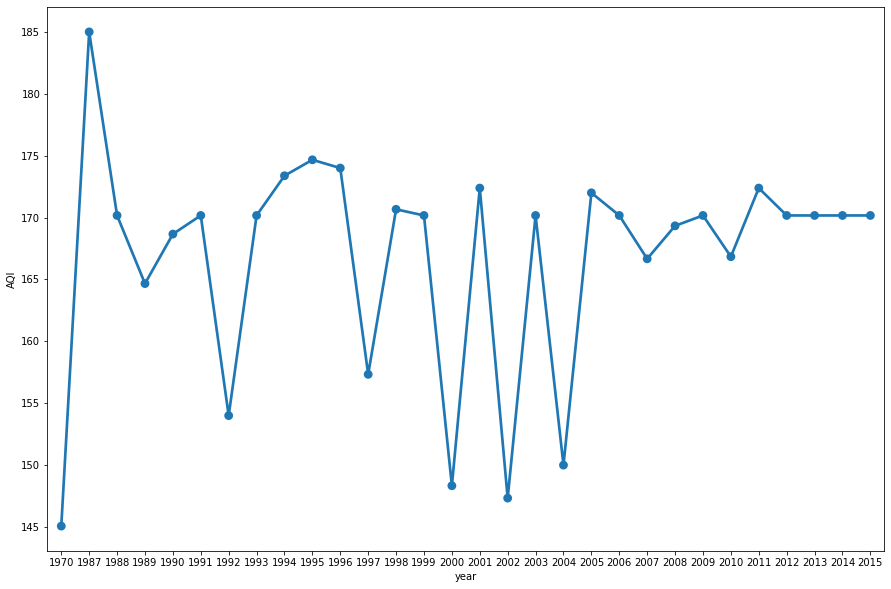

In [20]:
# EDA (EXPLORATORY DATA ANALYSIS STARTS HERE)
# Visualization of AQI across india WRT YEAR

dataset['date'] = pd.to_datetime(dataset['date'],format='%Y-%m-%d') # transforming the date column into '%Y-%m-%d' formate 
dataset['year'] = dataset['date'].dt.year                           # extracting year from the date column
dataset['year'] = dataset['year'].fillna(0.0).astype(int)           # filling nan values as 0
dataset = dataset[(dataset['year']>0)]                              # extracting only non null values

# groupig the dataset with respect to year and printing the AQI values for each year
df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
f,ax=plt.subplots(figsize=(15,10))
sns.pointplot(x='year', y='AQI', data=df)

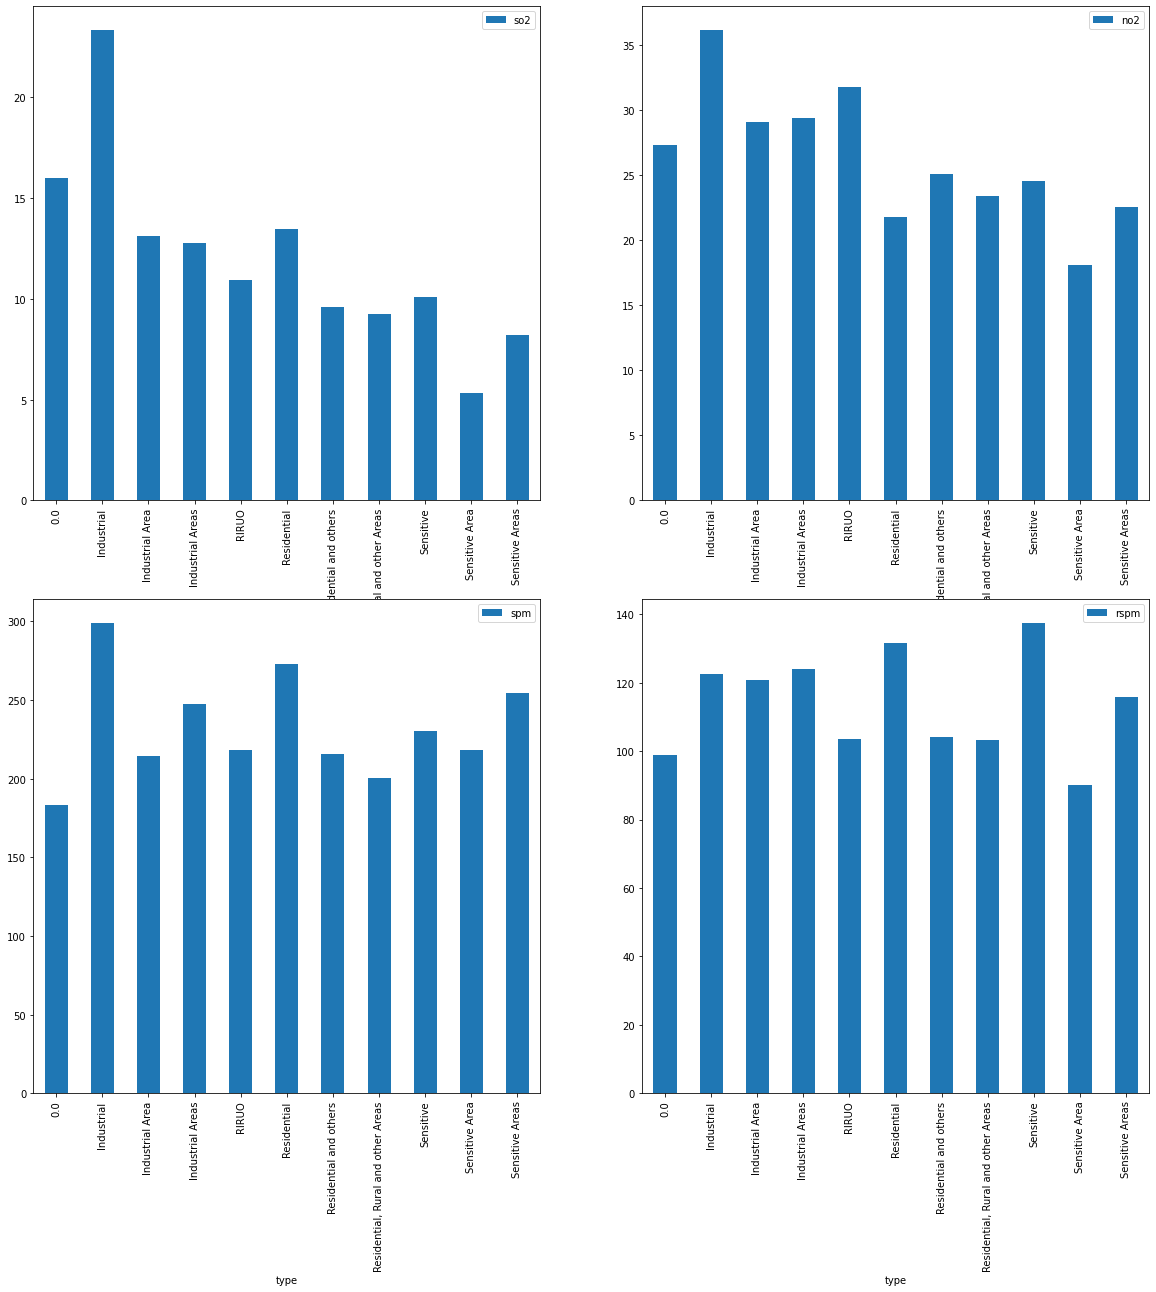

In [21]:
# Analysis of the pollutant concentration with respect to the type of the pollutants 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,40))
grp = dataset.groupby(["type"]).mean()["so2"].to_frame()  # grouping so2 concentration by type and plotting
grp.plot.bar(figsize = (20,20), ax=axes[0][0])

grp = dataset.groupby(["type"]).mean()["no2"].to_frame()  # grouping no2 concentration by type and plotting
grp.plot.bar(figsize = (20,20), ax=axes[0][1])

grp = dataset.groupby(["type"]).mean()["rspm"].to_frame()  # grouping rspm concentration by type and plotting
grp.plot.bar(figsize = (20,20), ax=axes[1][1])

grp = dataset.groupby(["type"]).mean()["spm"].to_frame()  # grouping spm concentration by type and plotting
grp.plot.bar(figsize = (20,20), ax=axes[1][0])

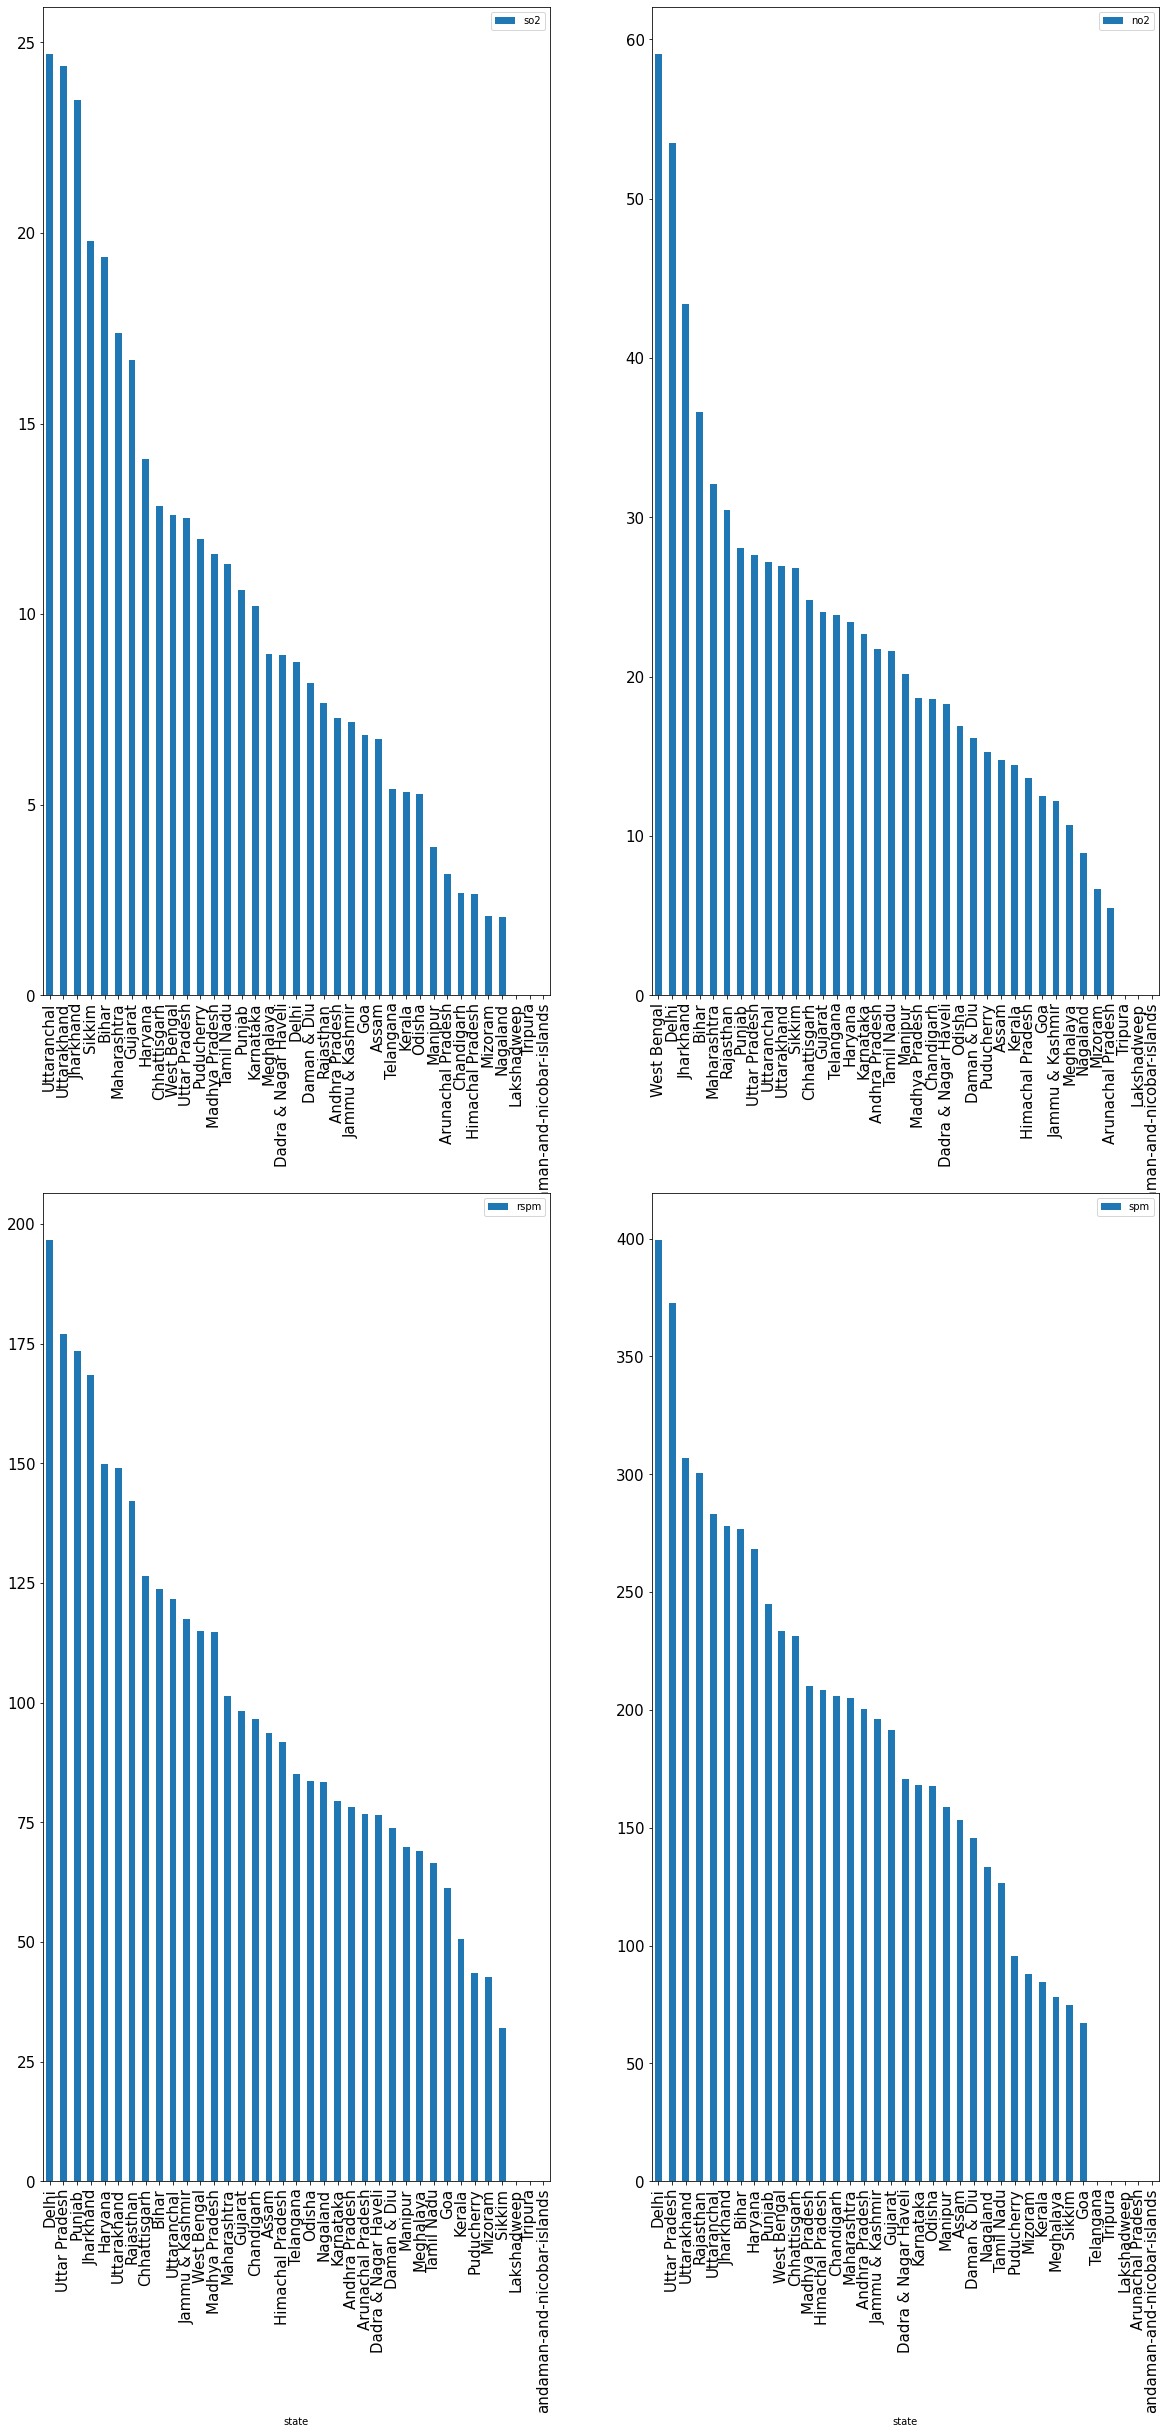

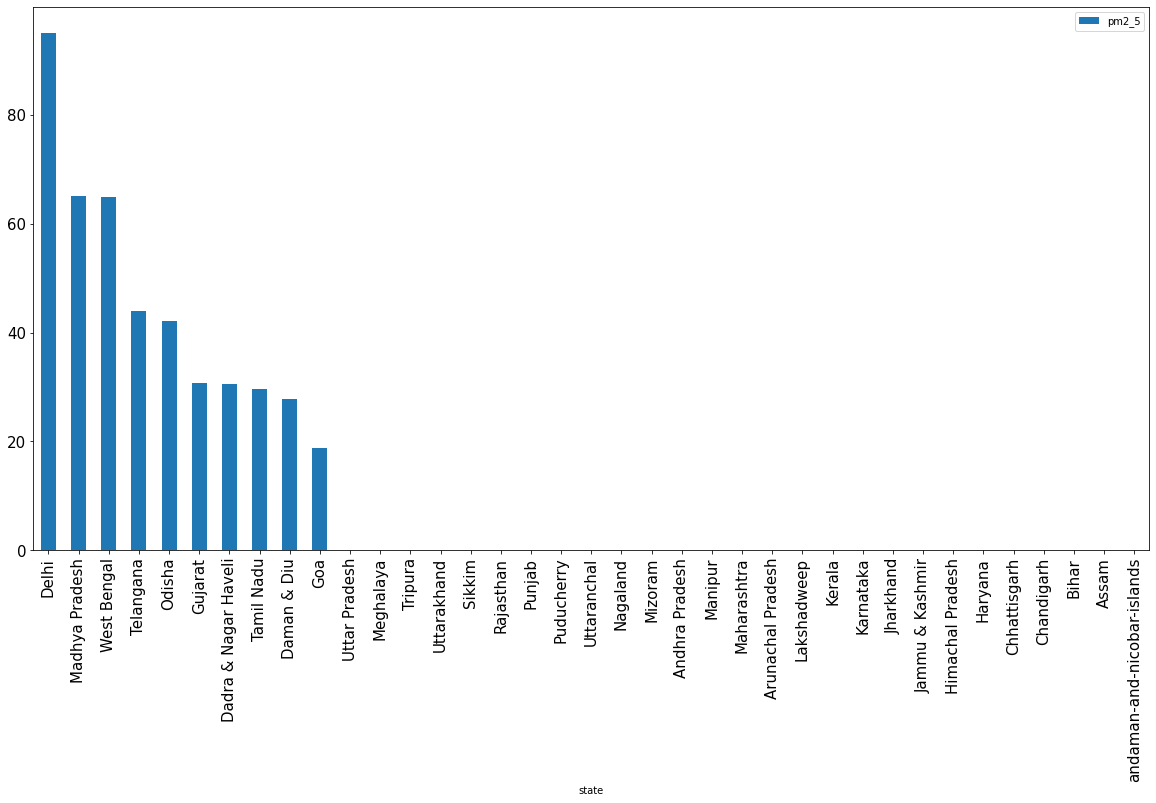

In [22]:
# analysis of pollutants with respect to state column


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,40))
state_pollution = dataset[['state','so2']].groupby('state').mean()  # grouping so2 concentration by state and taking mean
state_pollution.reset_index(inplace = True)
state_pollution.sort_values('so2', ascending= False, inplace = True) # sorting values in descending order
state_pollution.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15,  ax=axes[0][0])

state_pollution_no2 = dataset[['state','no2']].groupby('state').mean()   # grouping no2 concentration by state and taking mean
state_pollution_no2.reset_index(inplace = True)
state_pollution_no2.sort_values('no2', ascending= False, inplace = True)  # sorting values in descending order
state_pollution_no2.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15, ax=axes[0][1])

state_pollution_rspm = dataset[['state','rspm']].groupby('state').mean()   # grouping rspm concentration by state and taking mean
state_pollution_rspm.reset_index(inplace = True)
state_pollution_rspm.sort_values('rspm', ascending= False, inplace = True) # sorting values in descending order
state_pollution_rspm.plot(kind = 'bar', figsize= (20,40), x = 'state', fontsize= 15, ax=axes[1][0]) 


state_pollution_spm = dataset[['state','spm']].groupby('state').mean()   # grouping spm concentration by state and taking mean
state_pollution_spm.reset_index(inplace = True)
state_pollution_spm.sort_values('spm', ascending= False, inplace = True) # sorting values in descending order
state_pollution_spm.plot(kind = 'bar', figsize= (20,40), x = 'state', fontsize= 15, ax=axes[1][1])


state_pollution = dataset[['state','pm2_5']].groupby('state').mean()   # grouping pm25 concentration by state and taking mean
state_pollution.reset_index(inplace = True)
state_pollution.sort_values('pm2_5', ascending= False, inplace = True)  # sorting values in descending order
state_pollution.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15)

In [23]:
# pollutant wise analysis

#location with highest Sulphur dioxide,Nitrogen dioxide, RSPM and SPM separately content in air
states = dataset.groupby(['state','location'],as_index=False).mean()

print("Location with highest SO2 concentration :- \n")  # state with highest so2 concentration
print(states[states['so2']==(states['so2'].max())])
print("Location with highest NO2 concentration :- \n") # state with highest no2 concentration
print(states[states['no2']==(states['no2'].max())])
print("Location with highest RSPM concentration :- \n") # state with highest rspm concentration
print(states[states['rspm']==(states['rspm'].max())])
print("Location with highest SPM concentration :- \n") # state with highest spm concentration
print(states[states['spm']==(states['spm'].max())])

Location with highest SO2 concentration :- 

    state    location        so2  ...         spi         AQI         year
44  Bihar  Jamshedpur  46.284175  ...  161.781818  165.734476  1997.806061

[1 rows x 13 columns]
Location with highest NO2 concentration :- 

           state location       so2  ...        spi         AQI         year
314  West Bengal   Howrah  16.53373  ...  199.83137  202.836249  2005.950292

[1 rows x 13 columns]
Location with highest RSPM concentration :- 

         state        location       so2  ...         spi         AQI         year
118  Jharkhand  West Singhbhum  20.94702  ...  227.940746  232.908311  2011.238411

[1 rows x 13 columns]
Location with highest SPM concentration :- 

             state location      so2  ...        spi        AQI         year
289  Uttar Pradesh   Meerut  7.43325  ...  392.94424  392.94424  2009.616959

[1 rows x 13 columns]


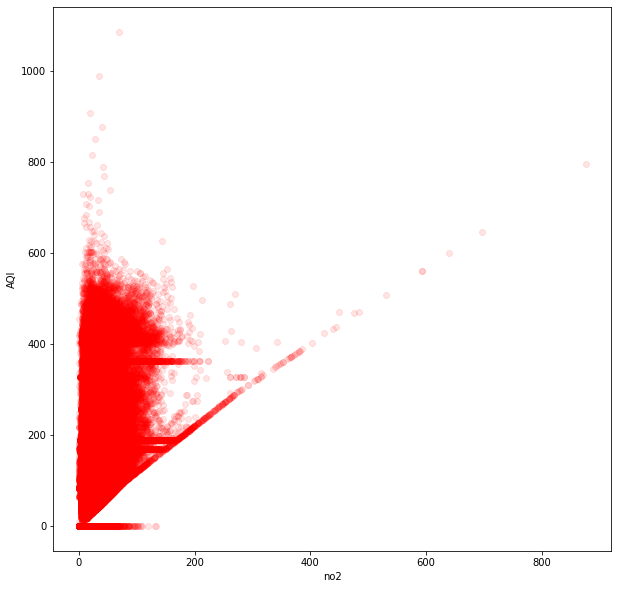

In [24]:
plt.figure(figsize=(10,10))
x1 = dataset['no2']
y1 = dataset['AQI']
plt.scatter(x1,y1, color = "red", alpha=0.1)
plt.xlabel('no2')
plt.ylabel('AQI')
plt.show()

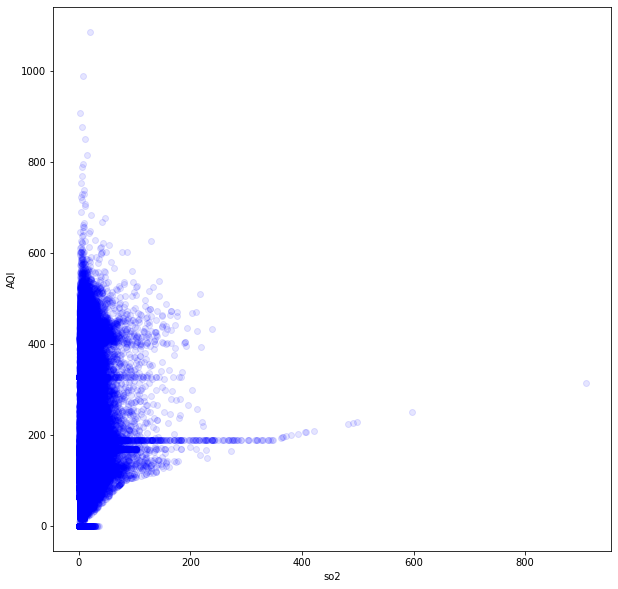

In [25]:
plt.figure(figsize=(10,10))
x1 = dataset['so2']
y1 = dataset['AQI']
plt.scatter(x1,y1, color = "blue", alpha=0.1)
plt.xlabel('so2')
plt.ylabel('AQI')
plt.show()

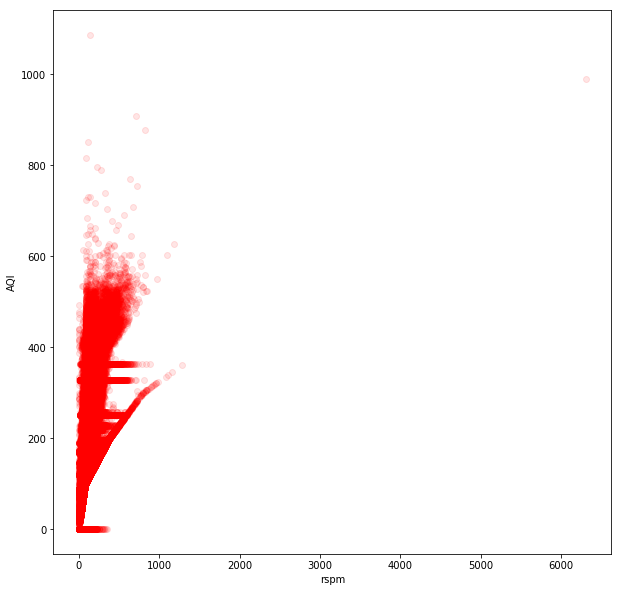

In [0]:
plt.figure(figsize=(10,10))
x1 = dataset['rspm']
y1 = dataset['AQI']
plt.scatter(x1,y1, color = "red", alpha=0.1)
plt.xlabel('rspm')
plt.ylabel('AQI')
plt.show()

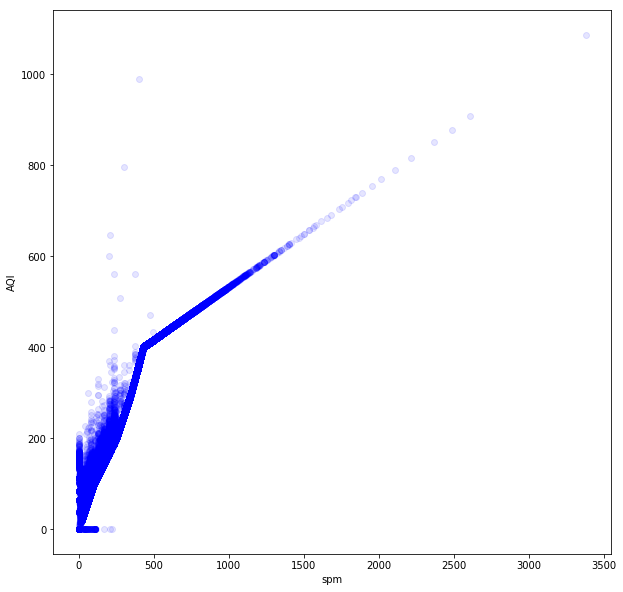

In [0]:
plt.figure(figsize=(10,10))
x1 = dataset['spm']
y1 = dataset['AQI']
plt.scatter(x1,y1, color = "blue", alpha=0.1)
plt.xlabel('spm')
plt.ylabel('AQI')
plt.show()

In [0]:
# LINEAR REGRESSION USING MLE (without intercept - theta0) STARTS HERE

# function : to compute theta values for maximum likelihood estimation
def max_lik_estimate(X, y):
  # X - independent variable (so2, no2, rspm, spm) - NX4 matrix
  # y - dependent variable (AQI) - NX1 vector 
    
  N, D = X.shape   # D=4
  theta_m1 = np.zeros((D, 1))         # assigning theta to zeros
  t1 = np.linalg.inv(np.dot(X.T, X))  # (X.T*X)^-1
  t2 = np.dot(X.T, y)                 # X.T*y
  theta_m1 = np.matmul(t1, t2)       # (X.T*X)^-1  X.T*y
  return theta_m1

In [0]:
def predict_with_estimate(Xtest, theta):
  prediction = np.dot(Xtest, theta)   # Xtest*theta
  return prediction

In [28]:
# MLE WITHOUT INTERCEPT

X_1=dataset[['so2','no2','rspm','spm']]  # pollutants- independent variables
y_1=dataset['AQI']   # target variable - dependent variables

# dividing the X values into 80% training and 205 testing values
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2)

# reshaping the X and y train test matrices 
y_test = np.array(y_test).reshape(-1,1)    
y_train = np.array(y_train).reshape(-1,1)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print(X_train.shape)

# calculating theta on the basis of X train and y train set
theta_m1 = max_lik_estimate(X_train, y_train)

# predicting the AQI on y test set
ml_prediction = predict_with_estimate(X_test, theta_m1)
print(' MLE WITHOUT INTERCEPT RMSE:%.2f '% np.sqrt(mean_squared_error(y_test, ml_prediction)))

(348593, 4)
 MLE WITHOUT INTERCEPT RMSE:23.16 


In [0]:
# MLE WITH INTERCEPT
def linear_regression_mle(X, y):
  # X - independent variable (so2, no2, rspm, spm) - NX4 matrix
  # y - dependent variable (AQI) - NX1 vector 
    
  N, D = X.shape
  X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
  theta_aug = np.zeros((D+1, 1)) # new theta vector of size (D+1) x 1

  # applying maximum likelihood etimation formula
  Xaug_t = X_aug.transpose()
  p = np.dot(Xaug_t,X_aug)
  i = np.linalg.inv(p)
  q = np.dot(i,Xaug_t)
  theta_aug_ml = np.dot(q,y) 
  return theta_aug_ml

In [0]:
def prediction_mle(X, theta):
  # X - independent variable (so2, no2, rspm, spm) - NX (D+1) matrix
  # theta - (D+1)X1 vector
  y = np.dot(X, theta)
  return y

In [31]:
N, D = X_test.shape
X_aug = np.hstack([np.ones((N,1)), X_test])       # stacking rows of ones in the first column of X_aug and remaining same as Xtest
theta = linear_regression_mle(X_train, y_train) # calculating theta based on MLE formula

print(X_train.shape, theta.shape) 
predictions = prediction_mle(X_aug, theta)   # predicting ytest by multiplying theta and Xtest

print(predictions.shape, y_test.shape)
print('r2_Square:%.2f '% r2_score(y_test, predictions))   # accuracy metric: r2 score
print('MLE WITH INTERCEPT RMSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions))) # accuracy metric : RMSE

(348593, 4) (5, 1)
(87149, 1) (87149, 1)
r2_Square:0.95 
MLE WITH INTERCEPT RMSE:20.85 


No handles with labels found to put in legend.


(435742, 1)
(435742, 4)


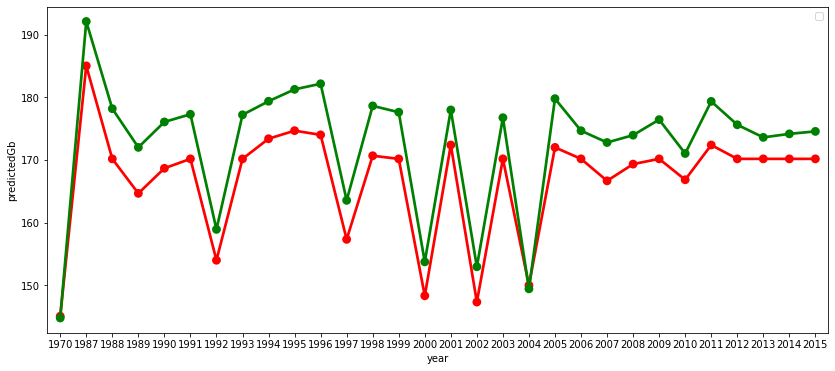

In [39]:
# to test
N1, D1 = X_1.shape
X_aug1 = np.hstack([np.ones((N1,1)), X_1])      
predictions1 = prediction_mle(X_aug1, theta)
print(predictions1.shape)
print(X_1.shape)
dataset['predictedGb'] = predictions1
df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
df1 = dataset[['predictedGb','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
f,ax=plt.subplots(figsize=(14,6))
plt.legend()
sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
sns.pointplot(x='year', y='predictedGb', data=df1, color='g', label="predicted")

In [0]:
# POLYNOMIAL REGRESSION
def poly_features1(X, k):
    # X - independent variable (so2, no2, rspm, spm) - NX4 matrix
    # k = degree of polynomial
    
    N = X.shape[0]
    ans = 0
    Phi = np.zeros((N, k+1))       # Phi matrix 
    first_row = np.ones((N, 1))    # column of N ones
    X = np.column_stack((first_row, X)) # stacking column of ones with X
    D = X.shape[1]
    
    for i in range(0, k+1):   # for every degree of polynomial till k
        for j in range(0, N): # for every example present the datset X
            ans=0
            for o in range(0, D):    # for every feature present in one example of the dataset
                ans = ans + X[j][o]**i   
            Phi[j][i] = ans   # assign PHI matrix
            
    return Phi

In [0]:
def nonlinear_features_maximum_likelihood(Phi, y):
  # Phi: features matrix for training inputs. Size of N x D
  # y: training targets. Size of N by 1
  # returns: maximum likelihood estimator theta_ml. Size of D x 1

  kappa = 1e-08 # 'jitter' term; good for numerical stability
  
  # MLE with non linear features formula
  k1 = np.linalg.inv(np.matmul(Phi.T, Phi) + kappa*np.identity(Phi.shape[1]))
  k2 = np.matmul(Phi.T, y)
  
  # maximum likelihood estimate
  theta_ml = np.matmul(k1, k2) ## <--Hint 5 : Use the expression of ML estimate as above
  return theta_ml

In [0]:
def nonlinear_features_maximum_likelihood_withoutk(Phi, y):
  # Phi: features matrix for training inputs. Size of N x D
  # y: training targets. Size of N by 1
  # returns: maximum likelihood estimator theta_ml. Size of D x 1

  #kappa = 1e-08 # 'jitter' term; good for numerical stability
  
  k1 = np.linalg.inv(np.matmul(Phi.T, Phi))
  k2 = np.matmul(Phi.T, y)
  
  # maximum likelihood estimate
  theta_ml = np.matmul(k1, k2) 
  return theta_ml

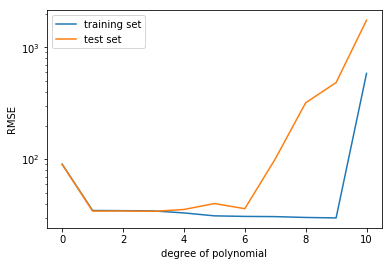

In [0]:
K_max = 10  # maximum degree of polynomial 

rmse_train = np.zeros((K_max+1,))   # rmse of training set
rmse_test = np.zeros((K_max+1,))    # rmse of testing set

# for every degree of polynomial till k+1
for k in range(K_max+1):
  # feature matrix
  Phi = poly_features1(X_train, k) 
  # maximum likelihood estimate
  theta_ml = nonlinear_features_maximum_likelihood(Phi, y_train) 
  # predict y-values of training set
  ypred_train = np.matmul(Phi,theta_ml)
  # RMSE on training set
  rmse_train[k] = np.sqrt(mean_squared_error(y_train, ypred_train)) 
  # feature matrix for test inputs
  Phi_test = poly_features1(X_test, k)
  # prediction (test set)
  ypred_test = np.matmul(Phi_test,theta_ml)
  # RMSE on test set
  rmse_test[k] = np.sqrt(mean_squared_error(y_test, ypred_test))

# plotting the training and testing set rmse with degree of polynomial
plt.figure()
plt.semilogy(rmse_train)  # this plots the RMSE on a logarithmic scale
plt.semilogy(rmse_test)   # this plots the RMSE on a logarithmic scale
plt.xlabel("degree of polynomial")
plt.ylabel("RMSE")
plt.legend(["training set", "test set"]);

In [0]:
# MAP ESTIMATION

def map_estimate_poly(Phi, y, sigma, alpha):
  # Phi: features matrix for training inputs. Size of N x D
  # y: training targets. Size of N by 1
  # returns: maximum likelihood estimator theta_ml. Size of D x 1

  k = np.power(sigma,2)/np.power(alpha,2)
  k1 = np.linalg.inv(np.dot(Phi.T, Phi) + k*np.identity(Phi.shape[1]))   # MAP FORMULA
  k2 = np.dot(Phi.T, y)
  
  # MAP Estimate
  theta_ml = np.dot(k1, k2) 
  return theta_ml

MLE MSE:36.11 
MAP MSE:31.50 


Text(0,0.5,'MLE')

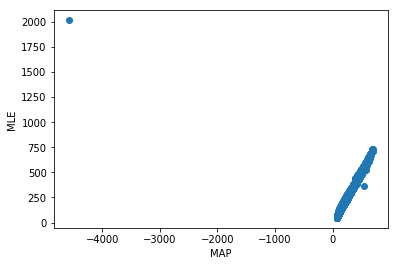

In [0]:
# get the MAP estimate
K = 6 # polynomial degree
# feature matrix

# calling polyfeatures function to calculate Phi
Phi = poly_features1(X_train, K)
sigma=500    
alpha=1

# theta_map - MAP ESTIMATE theta
theta_map = map_estimate_poly(Phi, y_train, sigma, alpha)

# maximum likelihood estimate
theta_ml = nonlinear_features_maximum_likelihood_withoutk(Phi, y_train)
Phi_test = poly_features1(X_test, K)

# MAP AND MLE PREDICTION
y_pred_map = np.dot(Phi_test,theta_map)
y_pred_mle = np.dot(Phi_test, theta_ml)

# printing RMSE FOR BOTH MAP AND MLE
print('MLE MSE:%.2f '% np.sqrt(mean_squared_error(y_test, y_pred_mle)))    # MLE RMSE
print('MAP MSE:%.2f '% np.sqrt(mean_squared_error(y_test, y_pred_map)))    # MAP RMSE

plt.scatter(y_pred_mle, y_pred_map)
plt.xlabel('MAP')
plt.ylabel('MLE')

In [0]:
# REGULARIZATION

def regularized_mle(Phi, y, lambda1):
  # Phi: features matrix for training inputs. Size of N x D
  # y: training targets. Size of N by 1
  # returns: maximum likelihood estimator theta_ml. Size of D x 1
  #kappa = 1e-08 # 'jitter' term; good for numerical stability
    
  k1 = np.linalg.inv(np.matmul(Phi.T, Phi) + lambda1*np.identity(Phi.shape[1]))
  k2 = np.matmul(Phi.T, y)
  
  # maximum likelihood estimate
  theta_ml = np.matmul(k1, k2) 
  return theta_ml

Text(0,0.5,'testing error rmse')

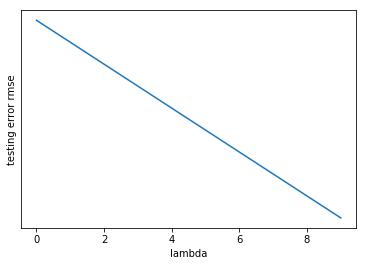

In [0]:
# get the MAP estimate
K = 4 # polynomial degree

rmse_reg = np.zeros((10,))     # rmse vector for each lambda 
for k in range(10):   # traversing different values of lambda
    Phi = poly_features1(X_train, K)   # feature matrix
    sigma=10
    alpha=1
    lambda1=k
    theta = regularized_mle(Phi, y_train, lambda1)   # MLE regularized estimate theta

    Phi_test = poly_features1(X_test, K) # feature matrix for test set
    y_pred = np.dot(Phi_test,theta)      # MlE regularized prediction 
    
    rmse_reg[k] =  np.sqrt(mean_squared_error(y_test, y_pred))
   
plt.semilogy(rmse_reg) # this plots the RMSE on a logarithmic scale
plt.xlabel('lambda')
plt.ylabel('testing error rmse')

In [0]:
X_1 = dataset[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_1 = dataset['AQI'] # target variable - AQI
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2)  # dividing int training and test set

# One Hot Encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
def gradient_boosting_classifier(X,y):

    # Gradient Boosting Regression
    GB = GradientBoostingRegressor()
    GB.fit(X_train, y_train)
    predictions = GB.predict(X_test)
    predictions1 = GB.predict(X)

    print(X_test.shape,X_train.shape,y_test.shape, predictions.shape,y_train.shape)
    print('r2_Square:%.2f '% r2_score(y_test, predictions))
    print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions)))
    print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(GB,X_train,y_train,cv=10).mean())

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    Kfold = cross_val_score(GB,X_train,y_train,cv=10).mean()

    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions, color = "red", alpha=0.1)
    plt.xlabel('Predictions')

    plt.ylabel('AQI')
    plt.title("Gradient Boosting Regression")
    plt.show()

    dataset['predictedGb'] = predictions1
    df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    df1 = dataset[['predictedGb','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    f,ax=plt.subplots(figsize=(15,10))
    sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
    sns.pointplot(x='year', y='predictedGb', data=df1, color='g', label="predicted")

    return rmse
   

(87149, 4) (348593, 4) (87149,) (87149,) (348593,)
r2_Square:1.00 
MSE:3.48 
KfoldCrossVal mean score using Linear regression is 0.998348710446286


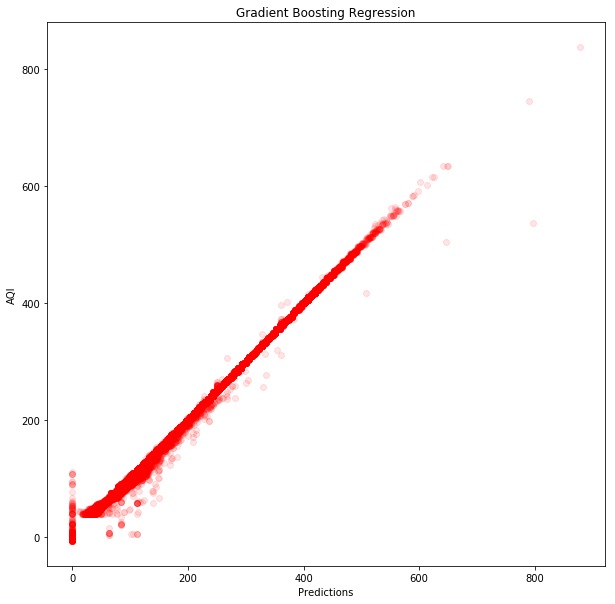

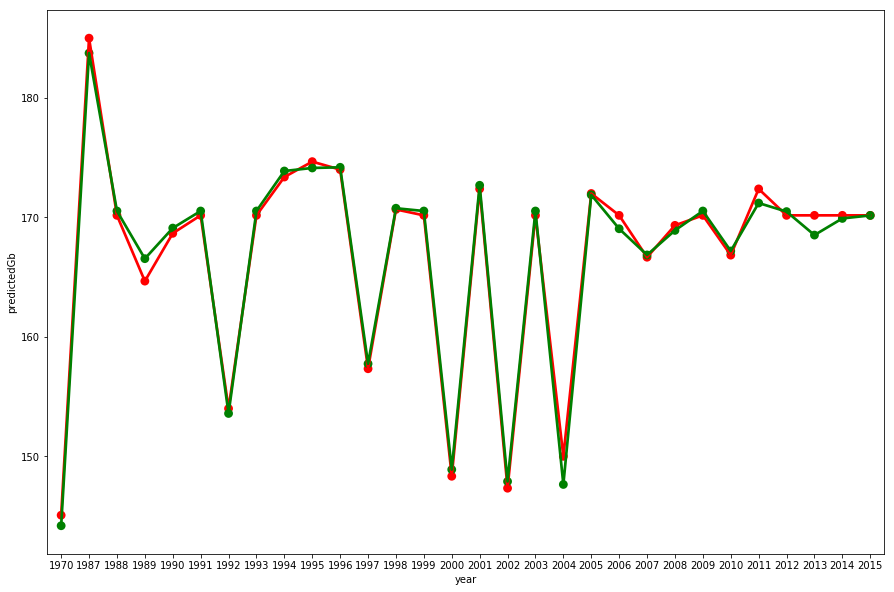

In [0]:
rmse_gbr = gradient_boosting_classifier(X_1,y_1)

In [0]:
# LINEAR REGRESSION USING LIBRARY

def linear_regression(X,y):

#Linear Regression
    LR = LinearRegression() # function call
    LR.fit(X_train, y_train) # fitting the model
    predictions = LR.predict(X_test) # testing  
    predictions1 = LR.predict(X) # prediction

    print(X_test.shape,X_train.shape,y_test.shape, predictions.shape,y_train.shape) 
    print('r2_Square:%.2f '% r2_score(y_test, predictions)) # printing predictions
    print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions))) # print mean squared error
    print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(LR,X_train,y_train,cv=10).mean())
    #printing mean score using k cross
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    plt.figure(figsize=(15,10))
    plt.scatter(y_test,predictions, color = "red", alpha=0.1) #plotting results of prediction
    #plt.plot(predictions, y_test, color = "green")
    plt.xlabel('Predictions')
    plt.ylabel('AQI')
    plt.title("Linear Prediction ")
    plt.show()

    dataset['predictedLr'] = predictions1
    df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    df1 = dataset[['predictedLr','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    f,ax=plt.subplots(figsize=(15,10))
    sns.pointplot(x='year', y='AQI', data=df, label="Actual") #plotting calculated value
    sns.pointplot(x='year', y='predictedLr', data=df1, color='g', label="predicted") # plotting predicted value

    return rmse

(87149, 4) (348593, 4) (87149,) (87149,) (348593,)
r2_Square:0.95 
MSE:20.10 
KfoldCrossVal mean score using Linear regression is 0.9488789182996952


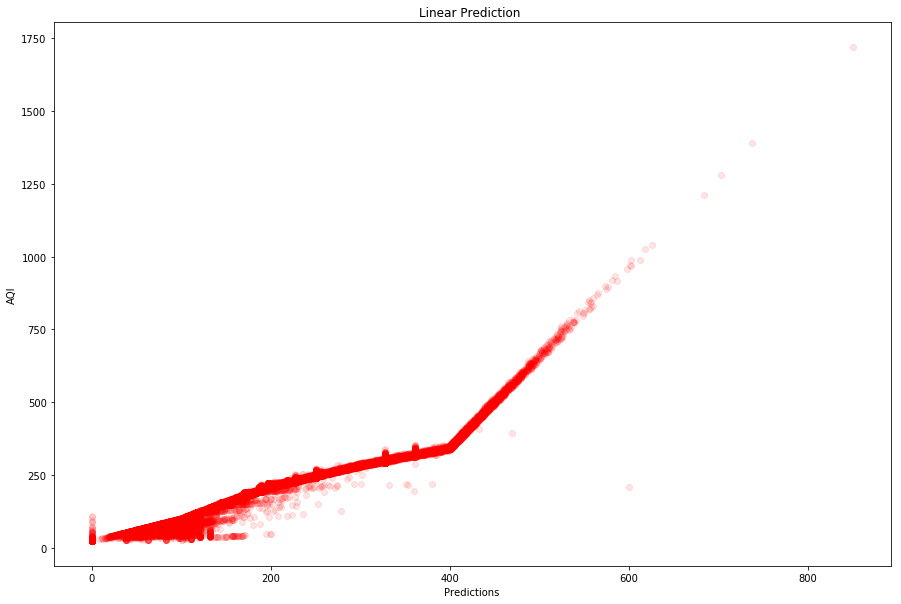

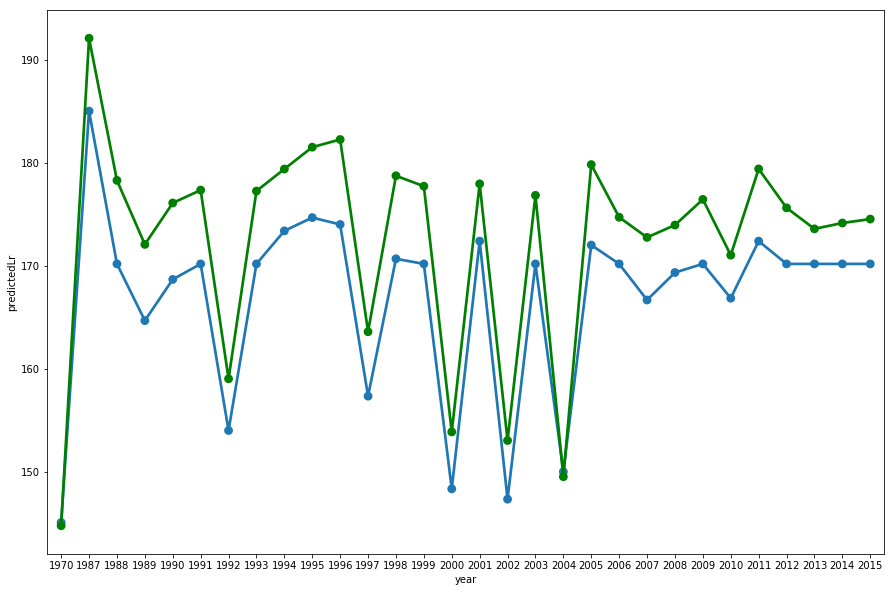

In [0]:
rmse_lr = linear_regression(X_1, y_1)

In [0]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_regressor(X,y):

    # Decision tree Regression
    DR = DecisionTreeRegressor(random_state=0) # fucntion call
    DR.fit(X_train, y_train) # fitting the model 
    predictions = DR.predict(X_test) # testing the model 
    predictions1 = DR.predict(X) # predicting the model

    print(X_test.shape,X_train.shape,y_test.shape, predictions.shape,y_train.shape)
    print('r2_Square:%.2f '% r2_score(y_test, predictions)) 
    print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions)))
    print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(DR,X_train,y_train,cv=10).mean())

    rmse = np.sqrt(mean_squared_error(y_test, predictions)) # calculating root mean squared error
    Kfold =  Kfold = cross_val_score(DR,X_train,y_train,cv=10).mean() # kfold cross validation scheme
    
    plt.figure(figsize=(15,10))
    plt.scatter(y_test,predictions, color = "red", alpha=0.1)
    plt.xlabel('Predictions')
    plt.ylabel('AQI')
    plt.title("Linear Prediction ")
    plt.show()

    dataset['predictedDtr'] = predictions1
    df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    df1 = dataset[['predictedDtr','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
    f,ax=plt.subplots(figsize=(15,10))
    sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual") # plotting real values
    sns.pointplot(x='year', y='predictedDtr', data=df1, color='skyblue', label="predicted") # plotting predicted values

    return rmse
   

(87149, 4) (348593, 4) (87149,) (87149,) (348593,)
r2_Square:1.00 
MSE:2.85 
KfoldCrossVal mean score using Linear regression is 0.9992877289936279


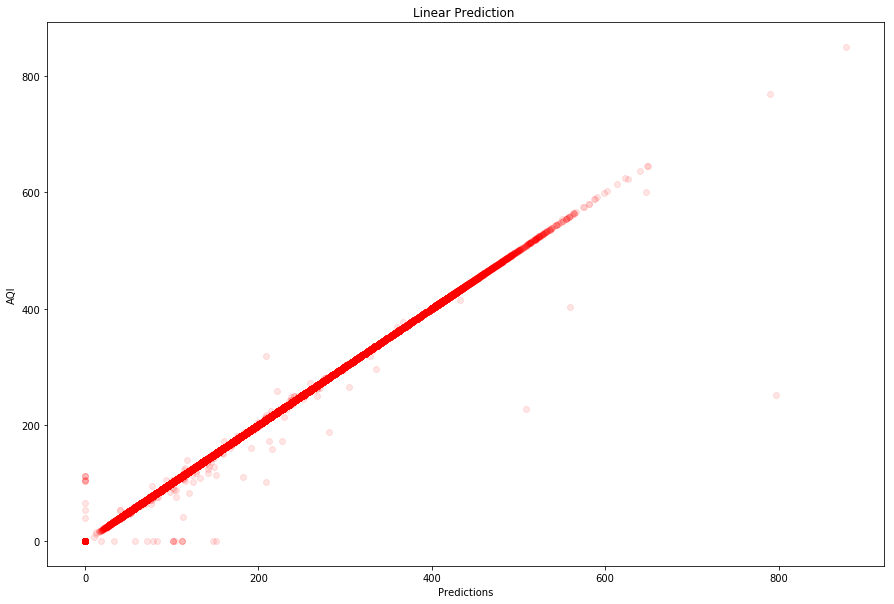

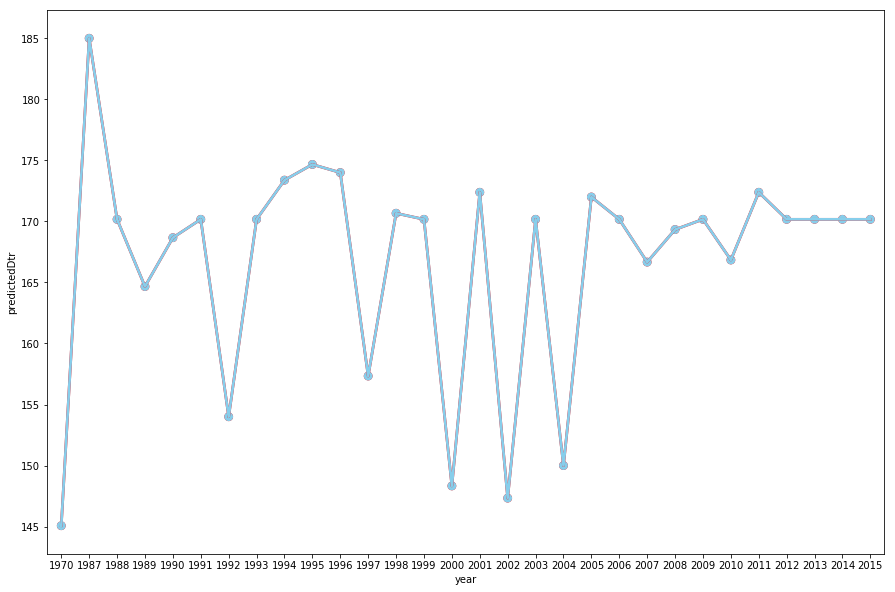

In [0]:
rmse_dtr = decision_tree_regressor(X_1,y_1)

In [0]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(X,y):

    #Random forest Regression
    RF = RandomForestRegressor(n_estimators = 50, random_state = 0) # function call
    RF.fit(X_train, y_train) # fitting data 
    predictions = RF.predict(X_test) # testing data
    predictions1 = RF.predict(X) # predicting data

    print(X_test.shape,X_train.shape,y_test.shape, predictions.shape,y_train.shape)
    print('r2_Square:%.2f '% r2_score(y_test, predictions))
    print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions)))
    print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(RF,X_train,y_train,cv=10).mean())

    rmse = np.sqrt(mean_squared_error(y_test, predictions)) # calculating root mean squared error
    Kfold = cross_val_score(RF,X_train,y_train,cv=10).mean() # k cross validation scheme
    
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions, color = "red", alpha=0.1)
    plt.xlabel('Predictions')
    plt.ylabel('AQI')
    plt.title("Linear Prediction ")
    plt.show()

    dataset['predictedDtr'] = predictions1
    df = dataset[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False) 
    df1 = dataset[['predictedDtr','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False) 
    f,ax=plt.subplots(figsize=(15,10))
    sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
    sns.pointplot(x='year', y='predictedDtr', data=df1, color='skyblue', label="predicted")
    
    return rmse

(87149, 4) (348593, 4) (87149,) (87149,) (348593,)
r2_Square:1.00 
MSE:2.72 
KfoldCrossVal mean score using Linear regression is 0.9994244645147186


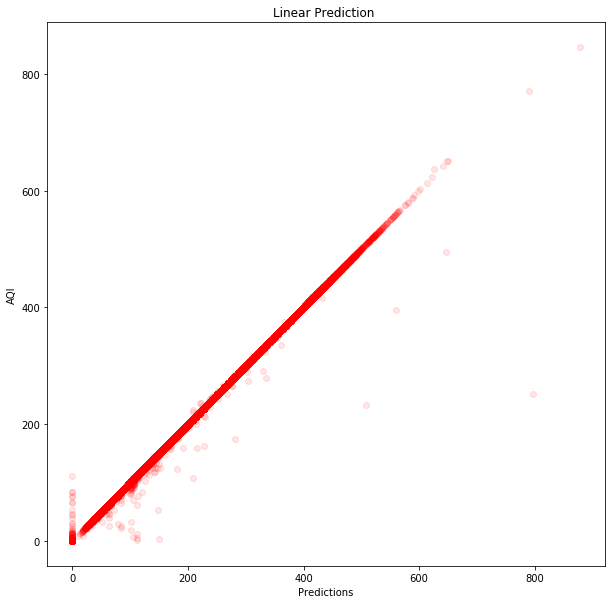

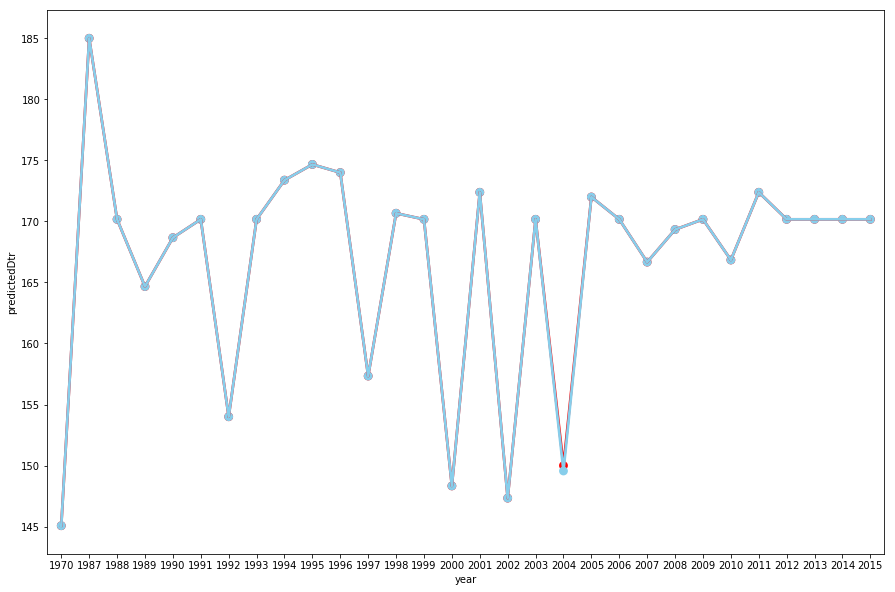

In [0]:
rmse_rf = random_forest_regressor(X_1,y_1)

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
objects = ('LR', 'DTR', 'RF', 'GBR')   # plotting rmse of all the regression techniques
y_pos = np.arange(len(objects))
performance = [rmse_lr, rmse_dtr, rmse_rf, rmse_gbr]  # rmse performance

# printing the bar chart showing RMSE of all the 4 regression techniques mentioned above
print(performance)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Error')
plt.ylabel('Regression techniques')
plt.title('RMSE analysis')

plt.show()